<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_QC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to single-cell RNA-seq I: pre-processing and quality control

This notebook demonstrates the use of the kallisto and bustools programs for pre-processing single-cell RNA-seq data. It streams in 1 million *C. elegans* reads, pseudoaligns them, and produces a *cells x genes* count matrix in about a minute. The notebook then performs some basic QC. It expands on a notebook prepared by Sina Booeshaghi for the Genome Informatics 2019 meeting, where he ran it in under 60 seconds during a 1 minute "lightning talk".

The notebook was written by A. Sina Booeshaghi, Lambda Lu and Lior Pachter. If you use the methods in this notebook for your analysis please cite the following publication, on which it is based:

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285

## Setup

In [0]:
# This is  used to time the running of the notebook
start_time <- Sys.time()

### Install R packages

In [1]:
install.packages(c("irlba", "ggpointdensity", "scico"), Ncpus = 2)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(Matrix)
library(irlba)
library(ggplot2) # Tidyverse is pre-installed, yay!
library(dplyr)
library(tidyr)
library(ggpointdensity)
library(scico)
theme_set(theme_bw())


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




### Install kb-python (includes kallisto and bustools)

In [0]:
system("pip3 install kb-python")

## Download required files

In [0]:
# The quantification of single-cell RNA-seq with kallisto requires an index. 
# Indices are species specific and can be generated or downloaded directly with `kb`. 
# Here we download a pre-made index for C. elegans (the idx.idx file) along with an auxillary file (t2g.txt) 
# that describes the relationship between transcripts and genes.
download.file("https://caltech.box.com/shared/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx",
destfile = "idx.idx")
download.file("https://caltech.box.com/shared/static/cflxji16171skf3syzm8scoxkcvbl97x.txt",
destfile = "t2g.txt")

## Pseudoalignment and counting

In this notebook we pseudoalign 1 million *C. elegans* reads and count UMIs to produce a *cells x genes* matrix. These are located at XXX and instead of being downloaded, are streamed directly to the Google Colab notebook for quantification. 
See [this blog post](https://sinabooeshaghi.com/2019/07/09/fasterq-to-count-matrices-for-single-cell-rna-seq/) for more details on how the streaming works.

The data consists of a subset of reads from [GSE126954](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126954) described in the paper:

* Packer, J., Zhu, Q. et al. [A lineage-resolved molecular atlas of C. elegans embryogenesis at single-cell resolution](https://science.sciencemag.org/content/365/6459/eaax1971/tab-e-letters). Science (2019). doi:10.1126/science.aax1971

### Run kallisto and bustools

In [7]:
system("kb count -i idx.idx -g t2g.txt --overwrite -t 2 -x 10xv2 https://caltech.box.com/shared/static/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz https://caltech.box.com/shared/static/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz",
intern = TRUE)

character(0)

## Basic QC



### Represent the cells in 2D

In [0]:
# Read in the count matrix that was output by `kb`.
mat <- readMM("/content/counts_unfiltered/cells_x_genes.mtx")

In [0]:
# Convert to dgCMatrix, which is a compressed, sparse matrix format
mat <- as(mat, "dgCMatrix")

In [5]:
dim(mat)

[1] 95372 22113

Here cells are in rows and genes are in columns, while usually in single cell analyses, cells are in columns and genes are in rows. Here most "cells" are empty droplets. What if we do PCA now? 

In [0]:
# Perform PCA
pca_res <- prcomp_irlba(mat, n = 2) # scales and centers by default
pca_x <- as.data.frame(pca_res$x)

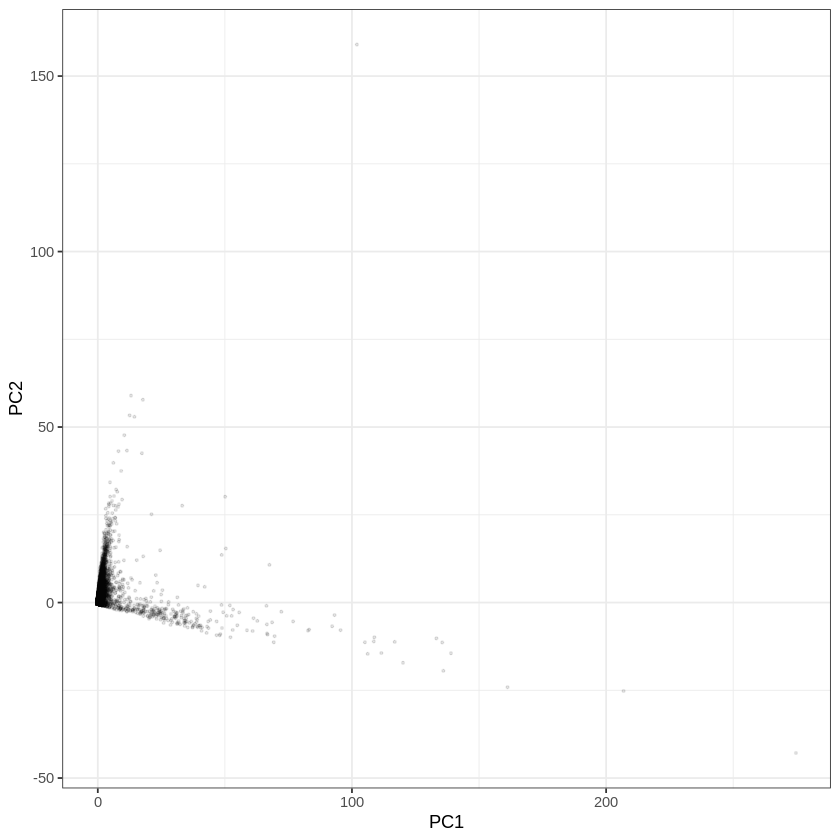

In [7]:
# Plot the cells in the 2D PCA projection
ggplot(pca_x, aes(PC1, PC2)) +
  geom_point(alpha = 0.1, size = 0.5)

While the PCA plot shows the overall structure of the data (in a 2D representation), it does not reveal the extent of read underrepresentation in some of the droplets. This can be seen by remaking the figure with points colored by density:

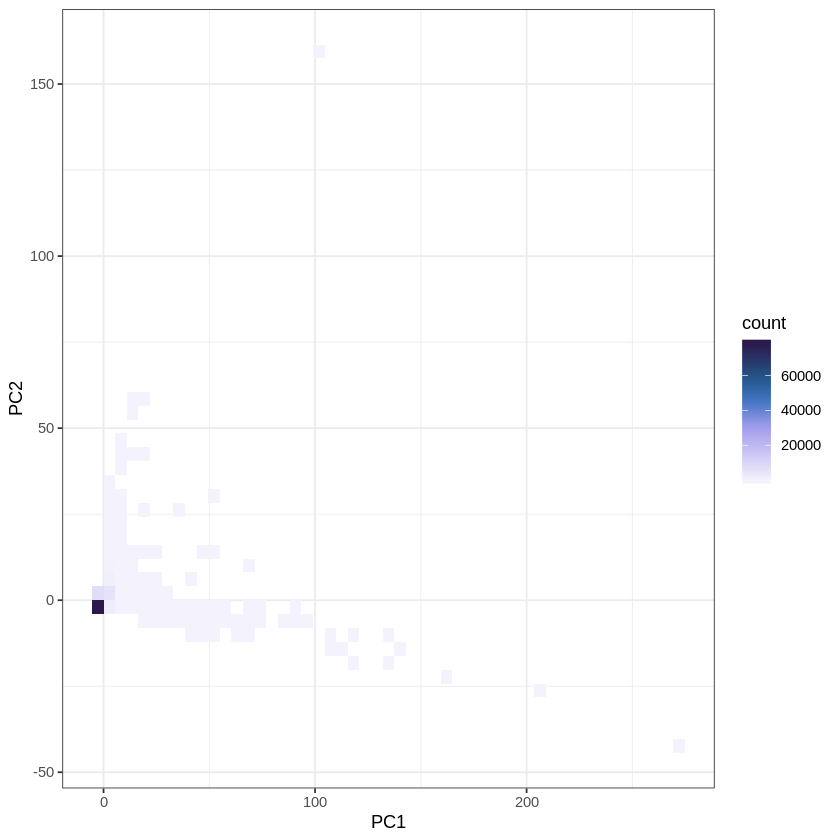

In [11]:
ggplot(pca_x, aes(PC1, PC2)) +
  geom_bin2d(bins = 50) +
  scale_fill_scico(palette = "devon", direction = -1, end = 0.95)

### Test for library saturation

In [0]:
df2 <- tibble(nCount = rowSums(mat),
              nGene = rowSums(mat > 0))

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1018 rows containing non-finite values (stat_bin2d).”


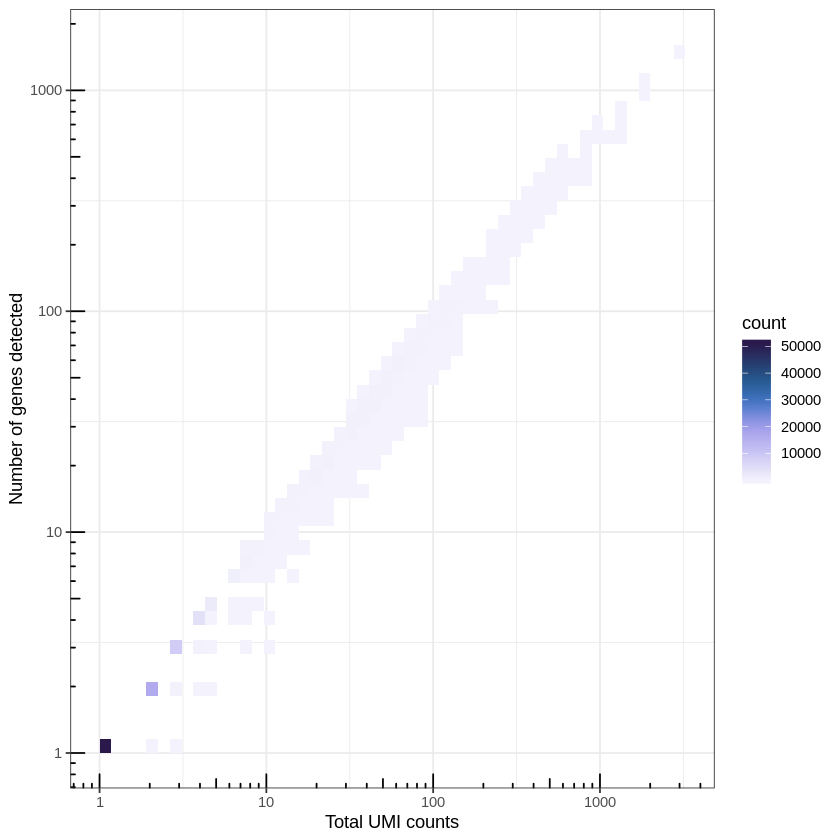

In [12]:
ggplot(df2, aes(nCount, nGene)) +
  geom_bin2d(bins = 50) +
  scale_fill_scico(palette = "devon", direction = -1, end = 0.95) +
  scale_x_log10() + scale_y_log10() + annotation_logticks() +
  labs(x = "Total UMI counts", y = "Number of genes detected")

### Examine the knee plot

Warning message:
“Transformation introduced infinite values in continuous x-axis”


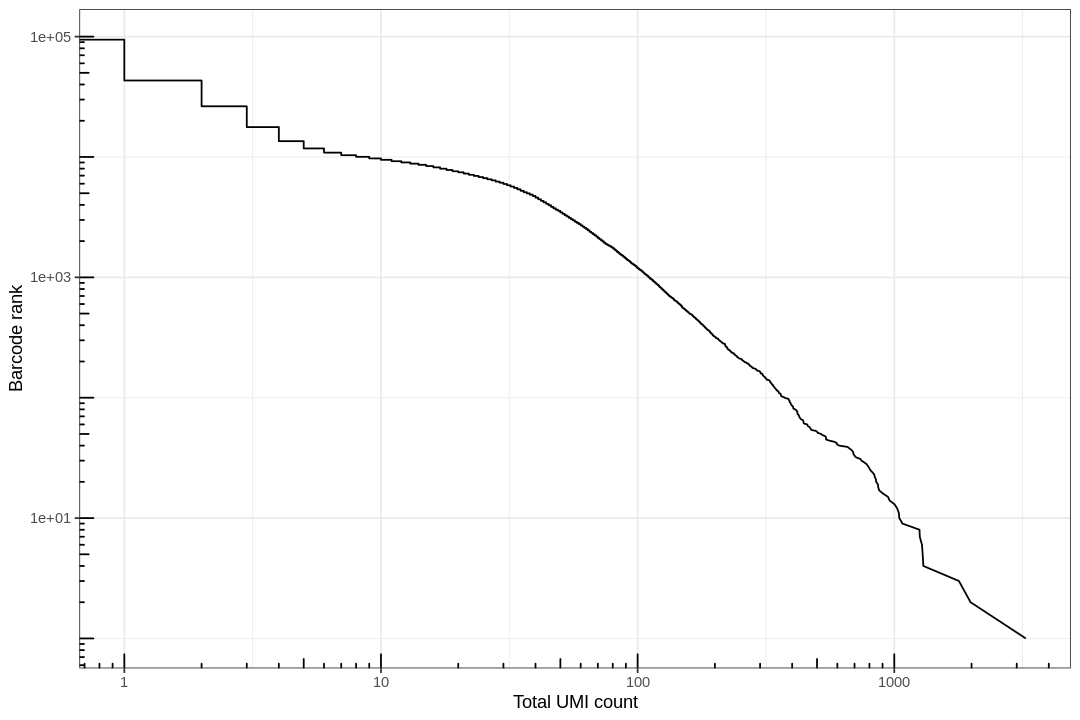

In [13]:
# Create the knee plot 
tot_counts <- rowSums(mat)
df <- tibble(total = tot_counts,
             rank = row_number(desc(total))) %>%
      distinct() %>%
      arrange(rank)
      
options(repr.plot.width=9, repr.plot.height=6)
ggplot(df, aes(total, rank)) +
  geom_path() +
  scale_x_log10() + scale_y_log10() + annotation_logticks() +
  labs(y = "Barcode rank", x = "Total UMI count")

In [0]:
mat_filtered <- mat[rowSums(mat) > 30, colSums(mat) > 0]

### Exercises

#### Exploring PCA subspaces

In [0]:
# Log normalize, the Seurat way
norm_mat <- log1p(sweep(mat_filtered, 1, rowSums(mat_filtered), FUN = "/") * 1e4)

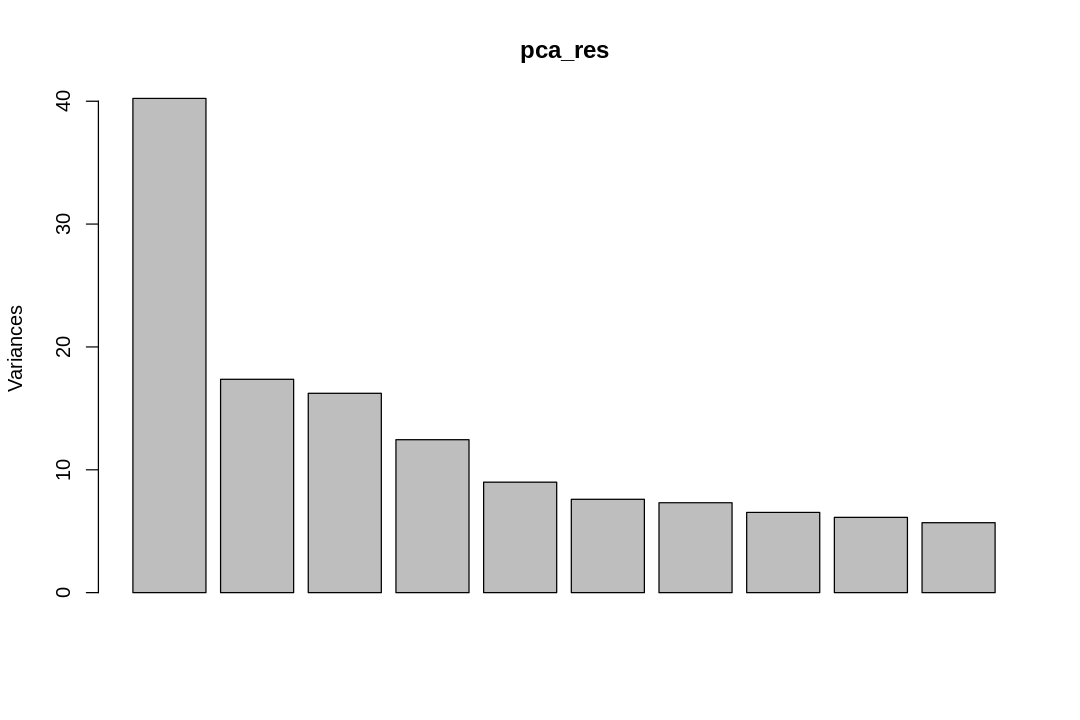

In [16]:
{pca_res <- prcomp_irlba(norm_mat, n = 15) # scales and centers by default
plot(pca_res)}

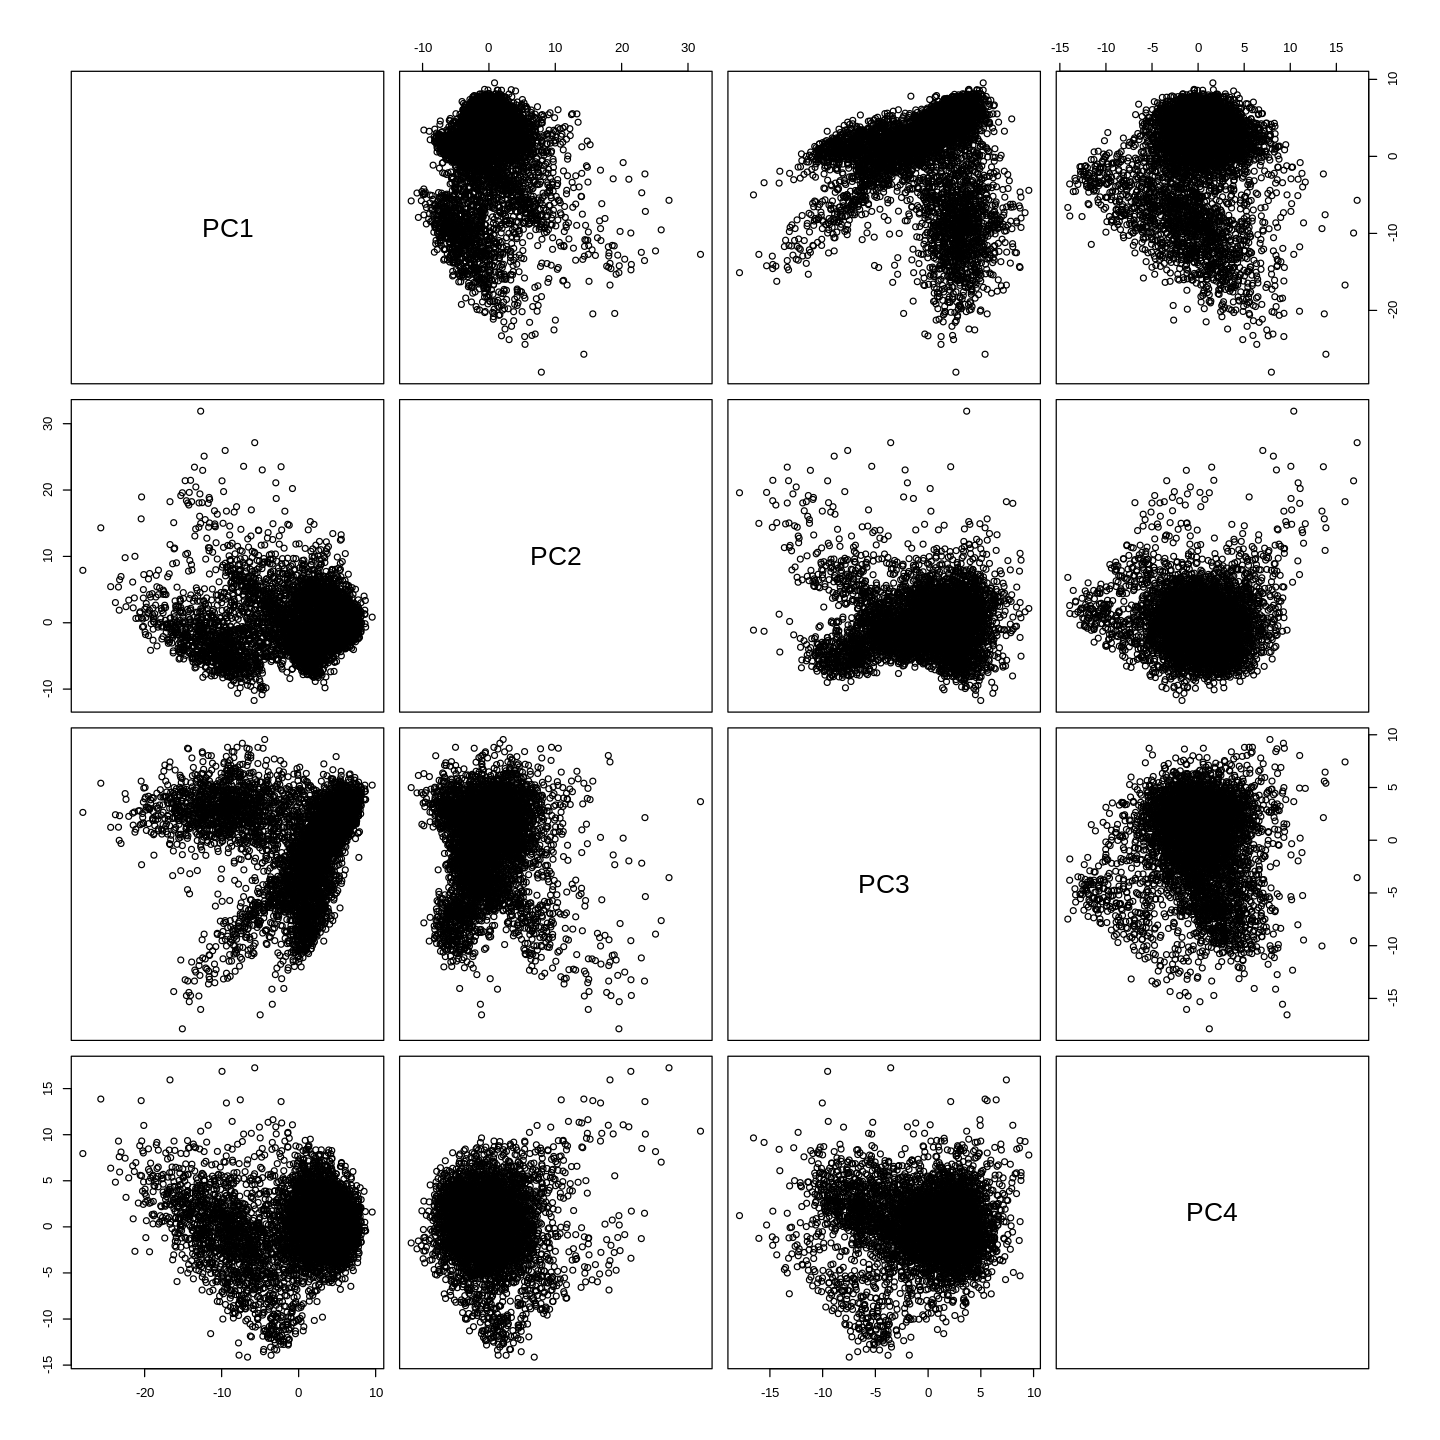

In [17]:
options(repr.plot.width=12, repr.plot.height=12)
pairs(pca_res$x[,1:4])

## Discussion

This notebook has demonstrated the pre-processing required for single-cell RNA-seq analysis. `kb` is used to pseudoalign reads and to generate a *cells x genes* matrix. Following generation of a matrix, basic QC helps to assess the quality of the data.

In [0]:
# Running time of the notebook
Sys.time() - start_time